<a href="https://colab.research.google.com/github/pichuu12/All-projects-and-Internship-tasks/blob/main/food_classification_project/Food_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOOD CLASSIFICATION - 101 categories


*   The goal of the project is to beat the DeepFood paper published in 2016 which categorizes 101 food categories with an accuracy of 77.4%

Dataset - [Drive Link](https://drive.google.com/file/d/1mdoM82J4u5kdrHN0rbE7eWpjDQhdXKNl/view?usp=sharing)


## Training and Testing Model with only 10% of original dataset

In [1]:
!nvidia-smi

Sat Mar 11 13:42:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing helper functions

In [2]:
#!wget https://github.com/pichuu12/All-projects-and-Internship-tasks/blob/main/helper_functions.py

In [3]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
  n_classes = cm.shape[0] 
  
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) 
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), 
         yticks=np.arange(n_classes), 
         xticklabels=labels, 
         yticklabels=labels)
  
 
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

 
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")
  
def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  
  if len(pred[0]) > 1: 
    pred_class = class_names[pred.argmax()] 
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] 

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


import zipfile

def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

import os

def walk_through_dir(dir_path):
 
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Getting dataset from google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip /content/gdrive/MyDrive/food_dataset/101_food_classes_10_percent.zip

Streaming output truncated to the last 5000 lines.
  inflating: 101_food_classes_10_percent/train/beet_salad/2450020.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/550087.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3132380.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/44885.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1967147.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1422905.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1380319.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/1336726.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/2808614.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/66574.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3537144.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3165387.jpg  
  inflating: 101_food_classes_10_percent/train/beet_salad/3391241.jpg  
  inflating: 101_f

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 images in '101_food_clas

### Setting up datasets

In [8]:
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [9]:
#checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor="val_accuracy", 
                                                         save_best_only=True) 

### Data Augmentation

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2), 
], name="data_augmentation")

### Base model setup

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer") 
x = data_augmentation(inputs)
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) 
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), 
                                           callbacks=[checkpoint_callback]) 

Epoch 1/5


237/237 [==============================] - 142s 517ms/step - loss: 3.3587 - accuracy: 0.2799 - val_loss: 2.4861 - val_accuracy: 0.4417
Epoch 2/5
237/237 [==============================] - 104s 436ms/step - loss: 2.2017 - accuracy: 0.4914 - val_loss: 2.0173 - val_accuracy: 0.5066
Epoch 3/5
237/237 [==============================] - 97s 403ms/step - loss: 1.8285 - accuracy: 0.5542 - val_loss: 1.8845 - val_accuracy: 0.5162
Epoch 4/5
237/237 [==============================] - 92s 386ms/step - loss: 1.5973 - accuracy: 0.6173 - val_loss: 1.7920 - val_accuracy: 0.5318
Epoch 5/5
237/237 [==============================] - 90s 380ms/step - loss: 1.4530 - accuracy: 0.6401 - val_loss: 1.7188 - val_accuracy: 0.5413


In [14]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 87s 110ms/step - loss: 1.5932 - accuracy: 0.5773


[1.5932080745697021, 0.5773465633392334]

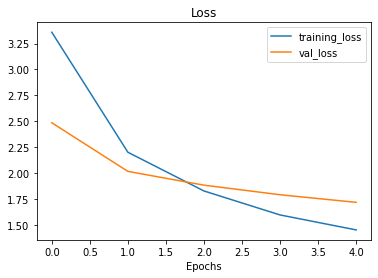

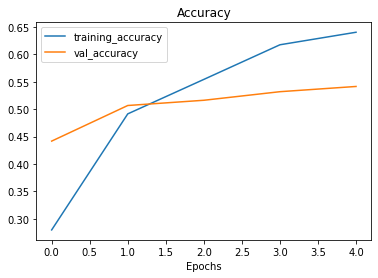

In [15]:
plot_loss_curves(history_all_classes_10_percent)

### Fine Tuning

In [16]:
# Unfreeze layers
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
#recompile
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), 
              metrics=['accuracy'])

In [18]:
#check for trainable layers
for layer in model.layers:
  print(layer.name, layer.trainable)

print('\n')
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation 

In [19]:
#training again for 5 more epochs
fine_tune_epochs = 10 

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), 
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) 

Epoch 5/10


237/237 [==============================] - 112s 419ms/step - loss: 1.2022 - accuracy: 0.6875 - val_loss: 1.7153 - val_accuracy: 0.5485
Epoch 6/10
237/237 [==============================] - 103s 434ms/step - loss: 1.0852 - accuracy: 0.7122 - val_loss: 1.6421 - val_accuracy: 0.5704
Epoch 7/10
237/237 [==============================] - 99s 418ms/step - loss: 1.0067 - accuracy: 0.7299 - val_loss: 1.6858 - val_accuracy: 0.5567
Epoch 8/10
237/237 [==============================] - 99s 416ms/step - loss: 0.9361 - accuracy: 0.7463 - val_loss: 1.6758 - val_accuracy: 0.5580
Epoch 9/10
237/237 [==============================] - 86s 359ms/step - loss: 0.8815 - accuracy: 0.7636 - val_loss: 1.6904 - val_accuracy: 0.5564
Epoch 10/10
237/237 [==============================] - 80s 335ms/step - loss: 0.8276 - accuracy: 0.7789 - val_loss: 1.6726 - val_accuracy: 0.5561


In [20]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 62s 79ms/step - loss: 1.5107 - accuracy: 0.5992


[1.5107148885726929, 0.5992475152015686]

* we got a slight boost from the previous model

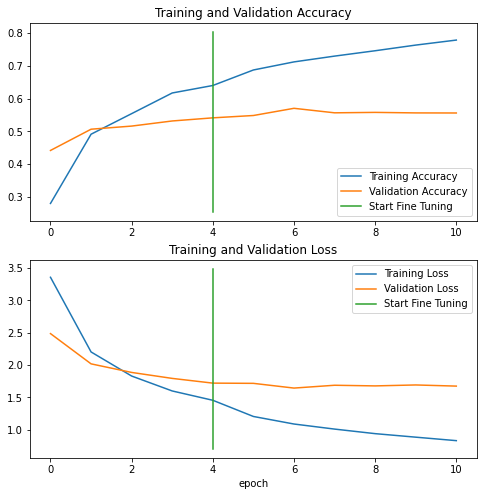

In [21]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [22]:
#saving model
model.save("/content/gdrive/MyDrive/101_food_class_10_percent_saved_big_dog_model")

TypeError: ignored

### Evaluating Model performance

In [23]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 67s 82ms/step


In [24]:
pred_probs.shape

(25250, 101)

In [25]:
pred_probs[:10]

array([[2.3128605e-01, 1.2322149e-04, 3.5251728e-01, ..., 5.2427025e-05,
        1.6423628e-03, 2.7755912e-02],
       [9.0629846e-01, 3.6664463e-08, 8.6788059e-04, ..., 1.4381254e-02,
        3.2284535e-07, 6.9981065e-06],
       [4.3589082e-01, 1.9297382e-02, 2.0884000e-02, ..., 7.0544705e-04,
        9.7694225e-04, 1.5061828e-03],
       ...,
       [2.6749891e-01, 9.2413575e-06, 1.1834354e-03, ..., 1.9954863e-01,
        1.0028821e-03, 2.9546666e-04],
       [2.0474796e-01, 2.1226844e-04, 3.9922342e-01, ..., 6.3258701e-04,
        1.4582722e-04, 1.1810777e-04],
       [7.5332540e-01, 7.0073810e-07, 1.0678995e-03, ..., 7.1290326e-03,
        1.4094868e-06, 4.4303262e-04]], dtype=float32)

In [26]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 2,  0,  0,  8,  8, 78, 29,  0,  2,  0])

In [28]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5992475247524752

In [30]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

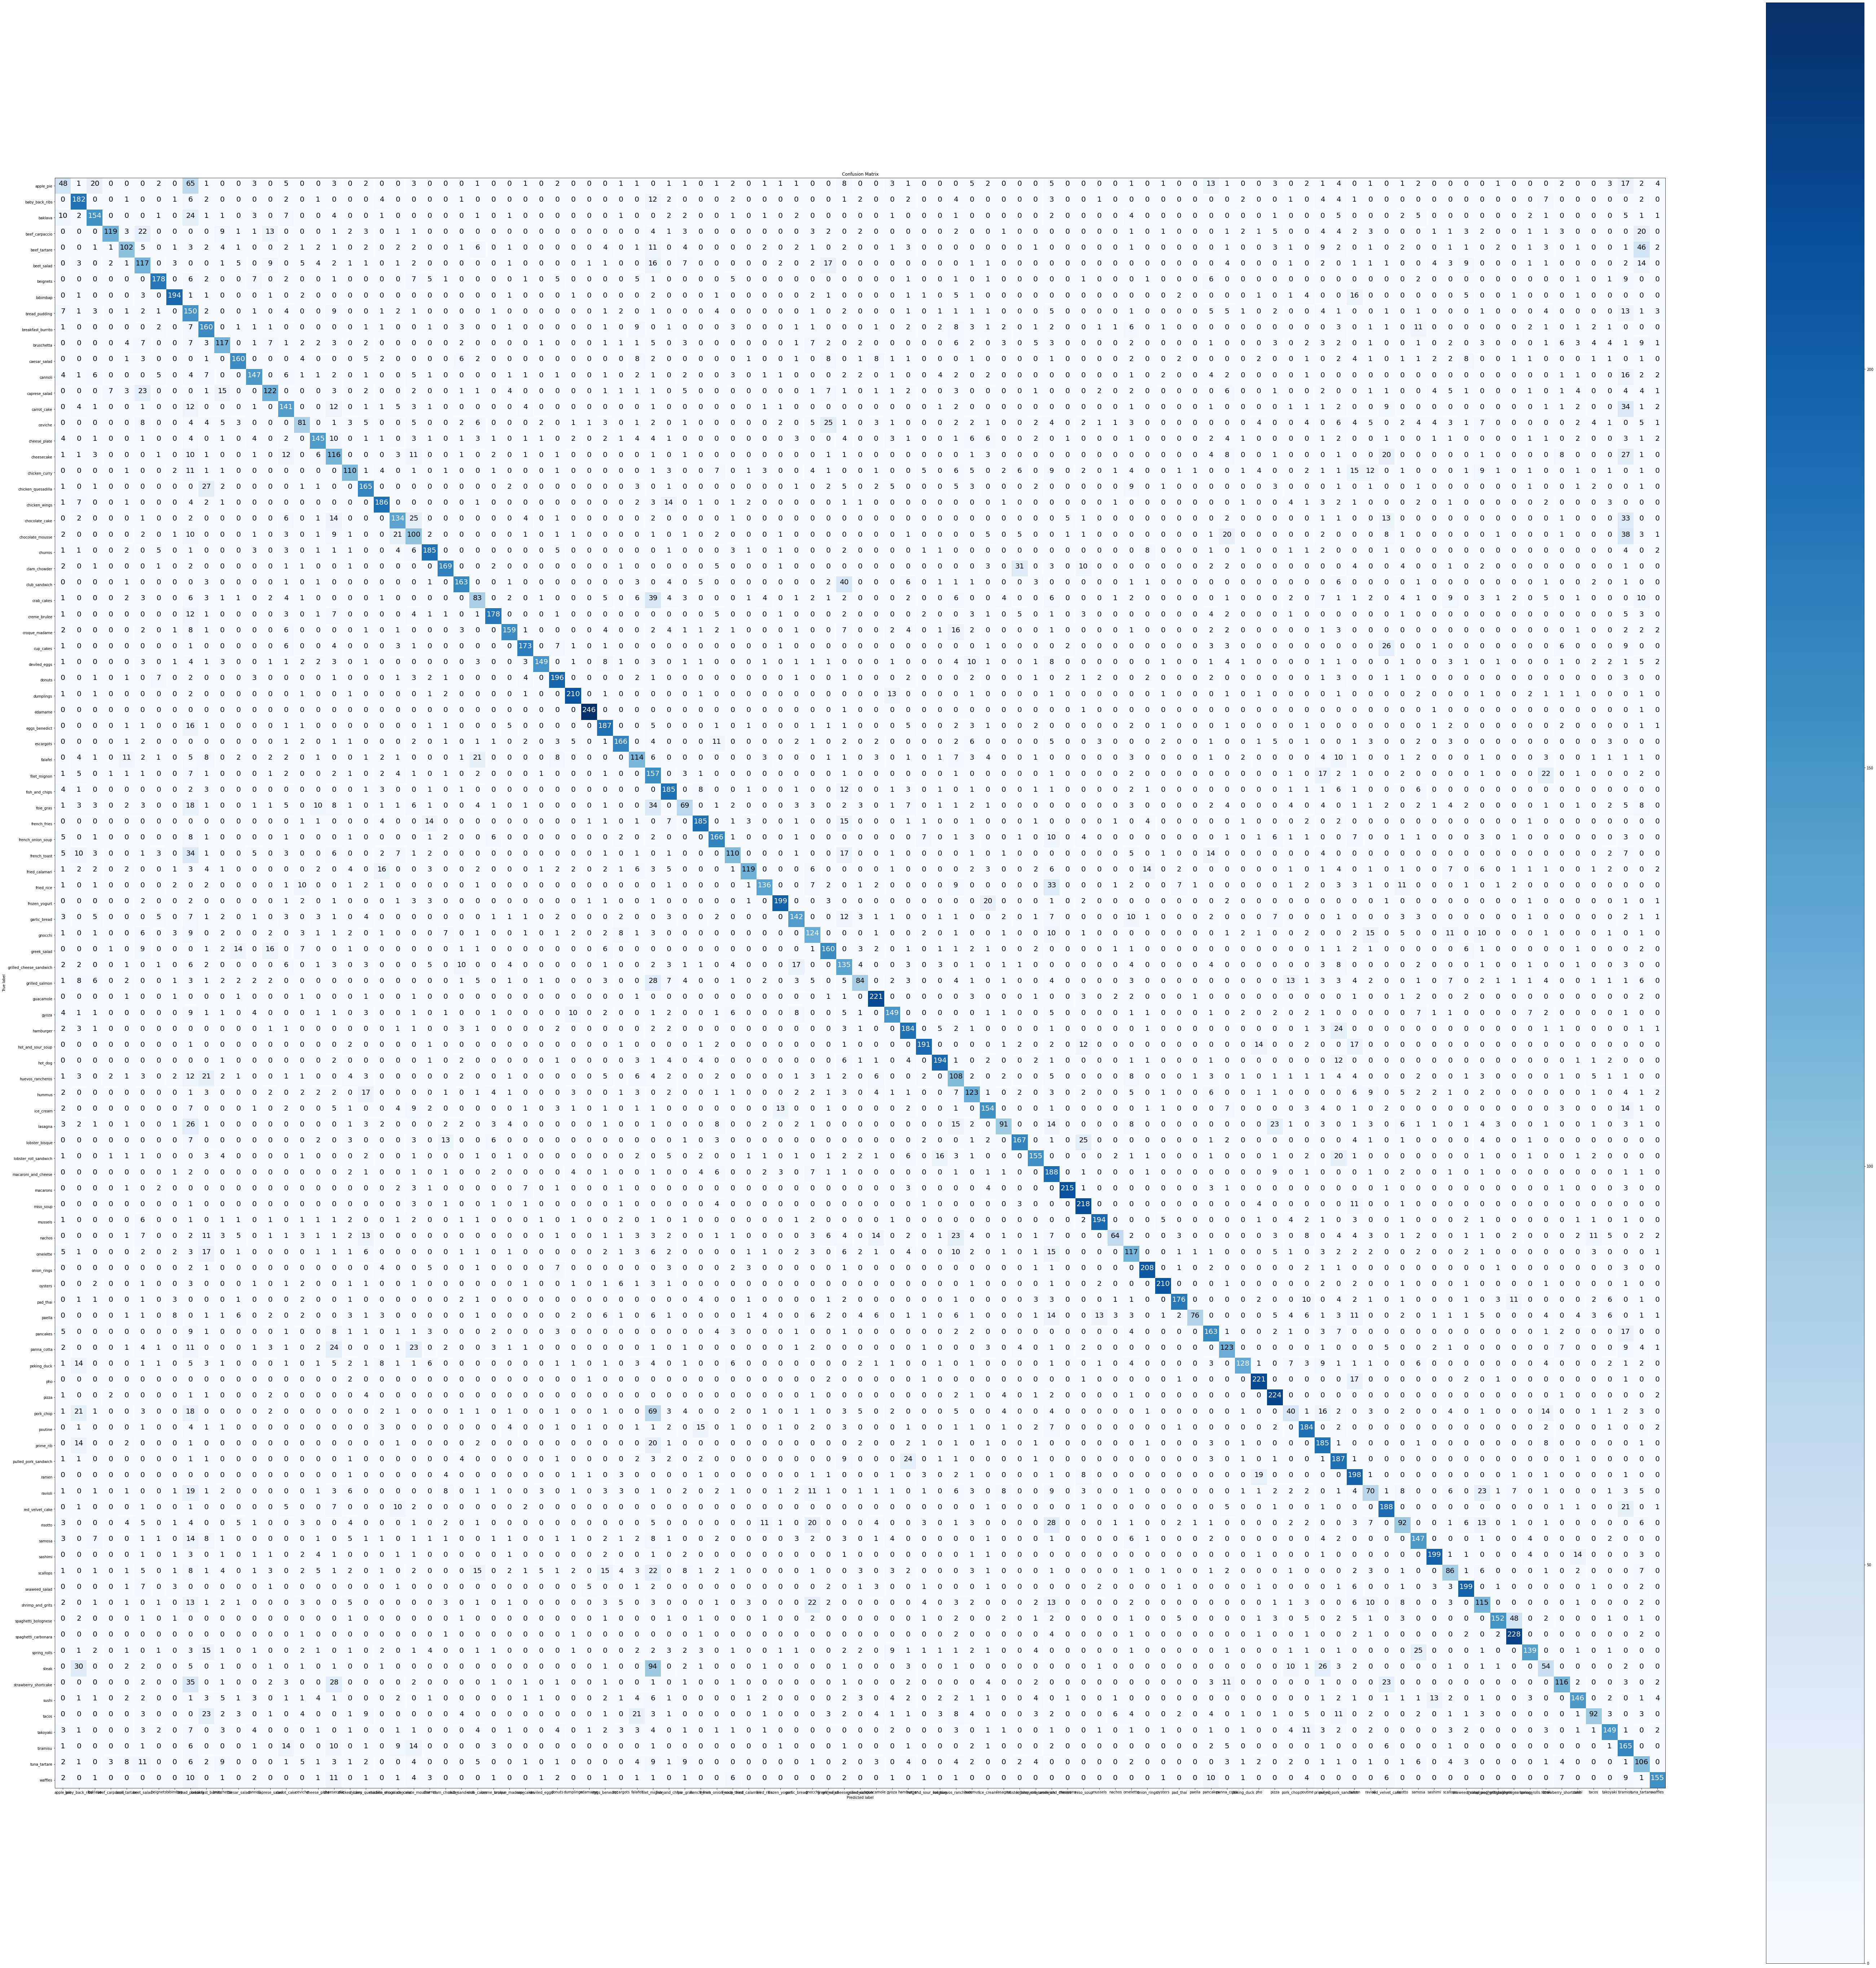

In [31]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.19      0.23       250
           1       0.54      0.73      0.62       250
           2       0.65      0.62      0.63       250
           3       0.86      0.48      0.61       250
           4       0.58      0.41      0.48       250
           5       0.38      0.47      0.42       250
           6       0.80      0.71      0.75       250
           7       0.82      0.78      0.80       250
           8       0.20      0.60      0.30       250
           9       0.43      0.64      0.51       250
          10       0.54      0.47      0.50       250
          11       0.74      0.64      0.69       250
          12       0.71      0.59      0.64       250
          13       0.60      0.49      0.54       250
          14       0.51      0.56      0.54       250
          15       0.49      0.32      0.39       250
          16       0.67      0.58      0.62       250
          17       0.34    

In [33]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.2926829268292683,
  'recall': 0.192,
  'f1-score': 0.23188405797101447,
  'support': 250},
 '1': {'precision': 0.5352941176470588,
  'recall': 0.728,
  'f1-score': 0.6169491525423728,
  'support': 250},
 '2': {'precision': 0.6497890295358649,
  'recall': 0.616,
  'f1-score': 0.6324435318275153,
  'support': 250},
 '3': {'precision': 0.8561151079136691,
  'recall': 0.476,
  'f1-score': 0.6118251928020565,
  'support': 250},
 '4': {'precision': 0.5795454545454546,
  'recall': 0.408,
  'f1-score': 0.47887323943661975,
  'support': 250},
 '5': {'precision': 0.38235294117647056,
  'recall': 0.468,
  'f1-score': 0.42086330935251803,
  'support': 250},
 '6': {'precision': 0.8018018018018018,
  'recall': 0.712,
  'f1-score': 0.7542372881355933,
  'support': 250},
 '7': {'precision': 0.8185654008438819,
  'recall': 0.776,
  'f1-score': 0.7967145790554415,
  'support': 250},
 '8': {'precision': 0.2, 'recall': 0.6, 'f1-score': 0.3, 'support': 250},
 '9': {'precision': 0.4278

In [34]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": 
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.23188405797101447,
 'baby_back_ribs': 0.6169491525423728,
 'baklava': 0.6324435318275153,
 'beef_carpaccio': 0.6118251928020565,
 'beef_tartare': 0.47887323943661975,
 'beet_salad': 0.42086330935251803,
 'beignets': 0.7542372881355933,
 'bibimbap': 0.7967145790554415,
 'bread_pudding': 0.3,
 'breakfast_burrito': 0.5128205128205128,
 'bruschetta': 0.5,
 'caesar_salad': 0.6866952789699571,
 'cannoli': 0.6433260393873085,
 'caprese_salad': 0.5386313465783665,
 'carrot_cake': 0.5351043643263756,
 'ceviche': 0.38848920863309355,
 'cheese_plate': 0.6196581196581196,
 'cheesecake': 0.38926174496644295,
 'chicken_curry': 0.501138952164009,
 'chicken_quesadilla': 0.6273764258555133,
 'chicken_wings': 0.7279843444227005,
 'chocolate_cake': 0.5583333333333333,
 'chocolate_mousse': 0.3759398496240602,
 'churros': 0.7254901960784313,
 'clam_chowder': 0.708595387840671,
 'club_sandwich': 0.692144373673036,
 'crab_cakes': 0.3816091954022989,
 'creme_brulee': 0.7510548523206751,
 'croq

In [35]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33        edamame  0.966601
63       macarons  0.901468
69        oysters  0.869565
68    onion_rings  0.833667
32      dumplings  0.830040
..            ...       ...
82        ravioli  0.328638
8   bread_pudding  0.300000
93          steak  0.260870
0       apple_pie  0.231884
77      pork_chop  0.217984

[101 rows x 2 columns]

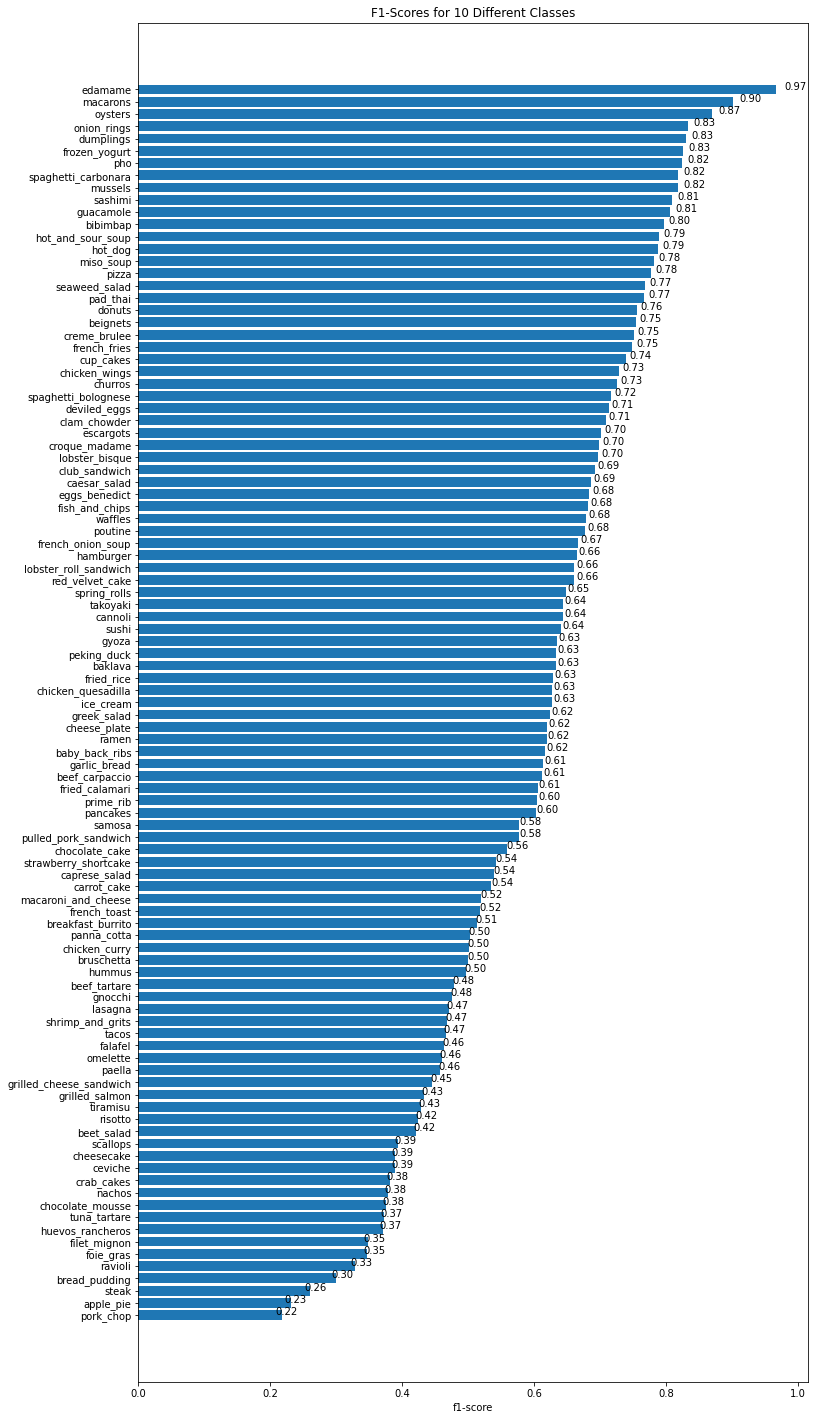

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); 

def autolabel(rects): 
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Making predictions on random images

1/1 [==============================] - 0s 30ms/step


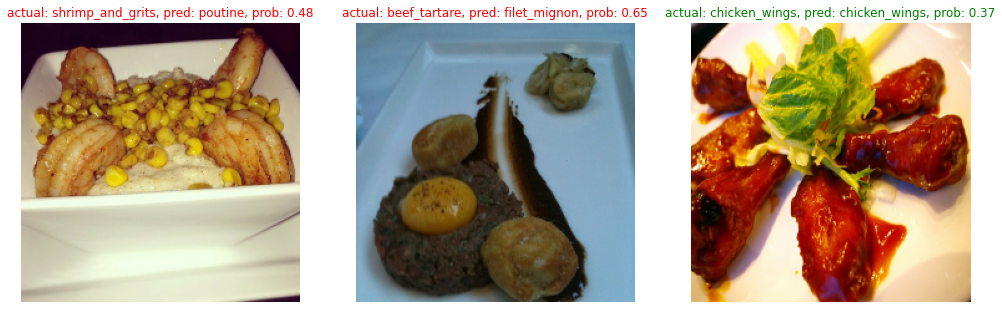

In [42]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

1/1 [==============================] - 0s 51ms/step


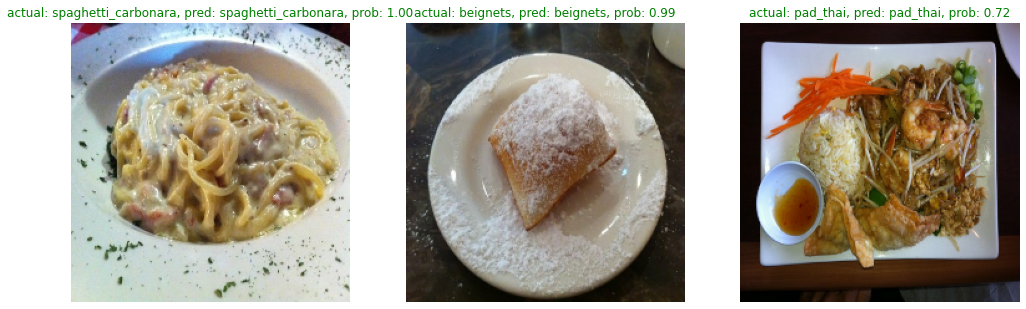

In [43]:
plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Most wrong predictions

In [44]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [45]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.352517        apple_pie          baklava  
1   0.906298        apple_pie        apple_pie  
2   0.435891        apple_pie        apple_pie  
3   0.297359        apple_pie    bread_pudding  
4   0.665874        apple_pie    bread_pudding

In [46]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.352517        apple_pie          baklava         False  
1   0.906298        apple_pie        apple_pie          True  
2   0.435891        apple_pie        apple_pie          True  
3   0.297359        apple_pie    bread_pudding         False  
4   0.665874        apple_pie    bread_pudding         False

In [47]:
# top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
4583   b'101_food_classes_10_percent/test/chicken_cur...      18      60   
11146  b'101_food_classes_10_percent/test/fried_rice/...      44      62   
5849   b'101_food_classes_10_percent/test/churros/254...      23      68   
179    b'101_food_classes_10_percent/test/apple_pie/3...       0       8   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
19430  b'101_food_classes_10_percent/test/pork_chop/3...      77       1   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
16271  b'101_food_classes_10_percent/test/mussels/140...      65      69   
23300  b'101_food_classes_10_percent/test/steak/17945...      93       1   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
3031   b'101_food_classes_10_percent/test/cannoli/134...      12      98   
9326   b'101_food_classes_10_percent/test/filet_migno...      37      79   
5652   b'101_food_classes_10_percent/test/chocolate_m...      22      98   

       pred_conf      y_true_classname     y_pred_classname  pred_correct  
11642   0.996810          garlic_bread           bruschetta         False  
10847   0.996672        fried_calamari          onion_rings         False  
18001   0.996523              pancakes             omelette         False  
191     0.996192             apple_pie               donuts         False  
17855   0.995999                paella              mussels         False  
23631   0.995936  strawberry_shortcake      red_velvet_cake         False  
4583    0.995042         chicken_curry       lobster_bisque         False  
11146   0.994913            fried_rice  macaroni_and_cheese         False  
5849    0.994804               churros          onion_rings         False  
179     0.994007             apple_pie        bread_pudding         False  
15142   0.992920        lobster_bisque            miso_soup         False  
19430   0.992918             pork_chop       baby_back_ribs         False  
21810   0.992736              scallops            cup_cakes         False  
23797   0.991596                 sushi              sashimi         False  
16271   0.991357               mussels              oysters         False  
23300   0.991160                 steak       baby_back_ribs         False  
10854   0.990973        fried_calamari          onion_rings         False  
3031    0.990368               cannoli             tiramisu         False  
9326    0.989726          filet_mignon            prime_rib         False  
5652    0.989608      chocolate_mousse             tiramisu         False

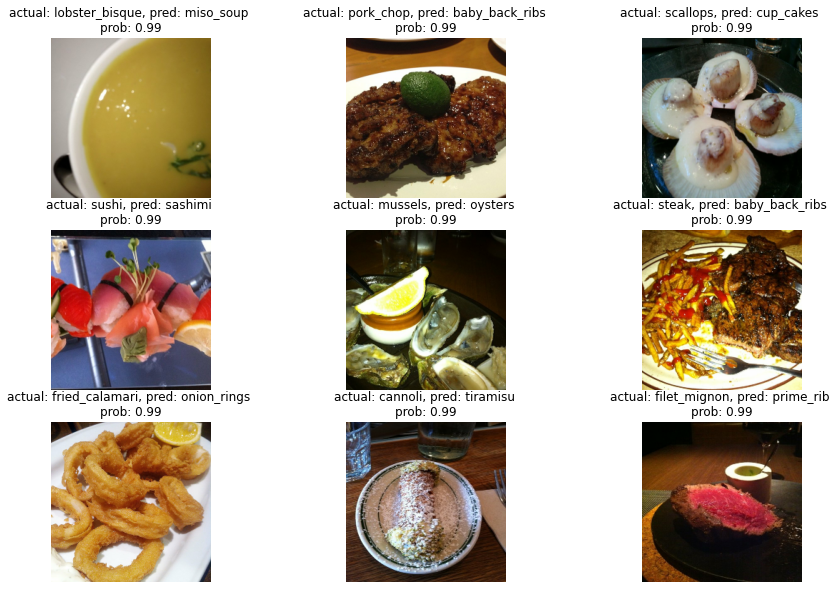

In [48]:
images_to_view = 9
start_index = 10 
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row 
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

### Testing model on custom images

In [55]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2023-03-11 14:43:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.08s   

2023-03-11 14:43:37 (165 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [56]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images
     

['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 53ms/step


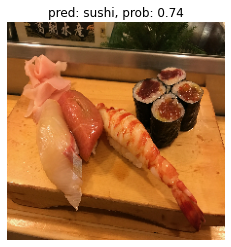

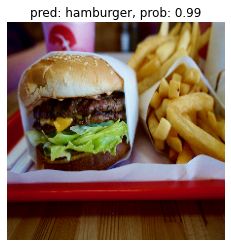

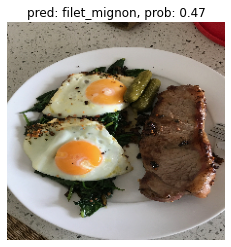

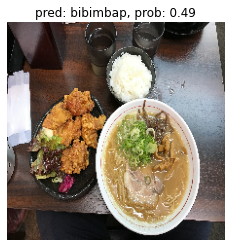

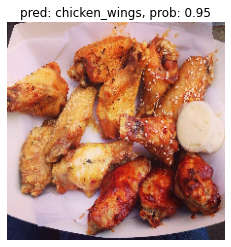

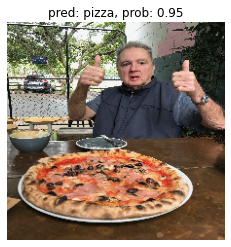

In [57]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 
  plt.figure()
  plt.imshow(img/255.) 
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)